In [1]:
import torch
torch.cuda.empty_cache()

Mounting the google drive and making sure we have the right stuff!

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Image Domain"
%ls

Mounted at /content/drive
/content/drive/My Drive/Image Domain
BasicEncoderRun.ipynb  InDomain/           OutDomain/        VAEncoderRun.ipynb
Cavity_images/         mean_train_kde.png  TrainingImages/
CNNEncoderRun.ipynb    model.pth           VAEInstall.ipynb


Importing the libraries!

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import glob

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, datasets

Checking if we have GPU access!

In [4]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


Preprocessing the images to have a size of 1024, 1024 for now because I don't know what else to do. Also loading the training images as a tensor. Made a function to load the images in.

In [5]:
from sklearn.preprocessing import MinMaxScaler
import torchvision.transforms.functional as T
TRAIN_UNDERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_nome_underfocus_only/train'
TRAIN_OVERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_nome_overfocus_only/train'
VAL_UNDERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_nome_underfocus_only/val'
VAL_OVERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_nome_overfocus_only/val'
CNL_UNDEROVERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_CNL_cleaned/train'
LOOPS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/loops_images'
RANDOM_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/random_images'
CHEN_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_chen'


def load_images(image_path, desired_height, desired_width, file_extension, contrast=False, contrastfactor = 0.5, blur = False, blur_factor = 10):
  image_list = []
  for filename in glob.glob(image_path + "/*" + file_extension):
      im=Image.open(filename)
      transform = transforms.Compose([ #Rotations, and rescaling, flipping, cropping
        transforms.Resize((desired_height, desired_width)),
        transforms.ToTensor()
      ])
      if(contrast == True):
        im = T.adjust_contrast(im, contrast_factor=contrastfactor)
      elif(blur == True):
        im = im.filter(ImageFilter.GaussianBlur(blur_factor))
      transformed_im = transform(im)
      image_list.append(transformed_im)
  for filename in glob.glob(image_path + "/*" + ".webp"):
    im=Image.open(filename)
    transform = transforms.Compose([ #Rotations, and rescaling, flipping, cropping
      transforms.Resize((desired_height, desired_width)),
      transforms.ToTensor()
    ])
    if(contrast == True):
      im = T.adjust_contrast(im, contrast_factor=contrastfactor)
    elif(blur == True):
      im = im.filter(ImageFilter.GaussianBlur(blur_factor))
    transformed_im = transform(im)
    image_list.append(transformed_im)
  num_images = len(image_list)
  num_channels, height, width = image_list[0].shape
  image_tensor = torch.zeros((num_images, 1, height, width), device='cuda')
  for i, image in enumerate(image_list):
    if(image.size()[0] == 3):
      image_tensor[i, 0, :, :] = torch.mean(image, dim=0)
    else:
      image_tensor[i, :, :, :] = image
  reshaped_tensor = image_tensor.view(num_images * height * width, 1)
  image_tensor = reshaped_tensor.view(num_images, 1, height, width)
  return image_tensor

Getting the splits for the train, test, and val

In [6]:
from sklearn.model_selection import train_test_split
train_image_underfocus_tensor = load_images(TRAIN_UNDERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
train_image_overfocus_tensor = load_images(TRAIN_OVERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
indomain_underfocus_image_tensor = load_images(VAL_UNDERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
indomain_overfocus_image_tensor = load_images(VAL_OVERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
indomain_image_tensor = torch.cat((indomain_underfocus_image_tensor, indomain_overfocus_image_tensor), 0)

train_tensor = torch.cat((train_image_underfocus_tensor, train_image_overfocus_tensor, indomain_image_tensor), 0)
Train_tensor, Other_tensor = train_test_split(train_tensor, test_size = 0.2)
Val_tensor, Test_tensor = train_test_split(Other_tensor, test_size = 0.5)
train_loader = torch.utils.data.DataLoader(Train_tensor, batch_size=16, shuffle=False)
valid_loader = torch.utils.data.DataLoader(Val_tensor, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(Test_tensor, batch_size=16, shuffle=True)

Making the architecture for the autoencoder


In [7]:
#Try running this with MNIST dataset
#If it works with MNIST, then see what is wrong

# VAE encoder
import torch.nn as nn
import torch.optim as optim


class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=6, stride=4, padding=1, padding_mode='zeros') # Dimensions 256*256*4
        self.leakyrelu1 = nn.LeakyReLU(negative_slope=0.01)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=6, stride=4, padding=1, padding_mode='zeros') # Dimensions 64*64*8
        self.leakyrelu2 = nn.LeakyReLU(negative_slope=0.01)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=6, stride=4, padding=1, padding_mode='zeros') # Dimensions 16*16*16
        self.leakyrelu3 = nn.LeakyReLU(negative_slope=0.01)
        #self.conv4 = nn.Conv2d(16, 32, kernel_size=6, stride=4, padding=1, padding_mode='zeros') # Dimensions 4*4*32
        self.fc_mean = nn.Linear(16*16*16, latent_dim)
        self.fc_log_var = nn.Linear(16*16*16, latent_dim)

    def forward(self, x):
        x = self.leakyrelu1(self.conv1(x))
        x = self.leakyrelu2(self.conv2(x))
        x = self.leakyrelu3(self.conv3(x))
        #x = torch.relu(self.conv4(x))
        x = x.view(-1, 16*16*16)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

# Reparameterization trick to sample from the latent space
def reparameterize(mean, log_var):
    std = torch.exp(0.5 * log_var)
    epsilon = torch.randn_like(std)
    return mean + std * epsilon

# VAE decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, 16*16*16)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        #self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=6, stride=4, padding=1, padding_mode='zeros')  # Dimensions 4*4*32 -> 16*16*16
        self.conv2 = nn.ConvTranspose2d(16, 8, kernel_size=6, stride=4, padding=1, padding_mode='zeros')   # Dimensions 16*16*16 -> 64*64*8
        self.conv3 = nn.ConvTranspose2d(8, 4, kernel_size=6, stride=4, padding=1, padding_mode='zeros')    # Dimensions 64*64*8 -> 256*256*4
        self.conv4 = nn.ConvTranspose2d(4, 1, kernel_size=6, stride=4, padding=1, padding_mode='zeros')    # Dimensions 256*256*4 -> 1024*1024*1
        self.output_dim = output_dim

    def forward(self, x):
        x = self.leakyrelu(self.fc1(x))
        x = x.view(-1, 16, 16, 16) #Reshape to match convolutions
        #x = torch.relu(self.conv1(x))
        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x)) #Using sigmoid for the output to scale between 0 and 1
        return x

# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = reparameterize(mean, log_var)
        reconstructed_output = self.decoder(z)
        return reconstructed_output, mean, log_var

    def get_latent_vector(self, x):
            with torch.no_grad():
                mean, log_var = self.encoder(x)
                z = reparameterize(mean, log_var)
            return z

# Loss function for VAE
def vae_loss(reconstructed, target, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed, target, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    print("Reconstruction Loss", reconstruction_loss)
    print("KL Divergence Loss", kl_divergence)
    return reconstruction_loss + kl_divergence

#Initializing the VAE model
input_dim = 1024*1024
latent_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)



#Setting the optimizer
optimizer = optim.Adam(vae.parameters(), lr = 0.001)

# Training
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        #data = data.view(-1, input_dim)
        optimizer.zero_grad()
        reconstructed, mean, log_var = vae(data)
        loss = vae_loss(reconstructed, data, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {}  Loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

# Testing
def test(epoch):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            #data = data.view(-1, input_dim)
            reconstructed, mean, log_var = vae(data)
            test_loss += vae_loss(reconstructed, data, mean, log_var).item()
    print('Test loss: {:.4f}'.format(test_loss / len(test_loader.dataset)))


# Training loop
num_epochs = 200
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test(epoch)

# Generating new samples
def generate_samples(decoder, n_samples=10):
    z = torch.randn(n_samples, latent_dim, device = device)
    samples = decoder(z)
    return samples

# Usage example
samples = generate_samples(vae.decoder)



Reconstruction Loss tensor(11591583., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
KL Divergence Loss tensor(0.6653, device='cuda:0', grad_fn=<MulBackward0>)
Reconstruction Loss tensor(11629134., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
KL Divergence Loss tensor(2.9667, device='cuda:0', grad_fn=<MulBackward0>)
Reconstruction Loss tensor(11603370., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
KL Divergence Loss tensor(1.8637, device='cuda:0', grad_fn=<MulBackward0>)
Reconstruction Loss tensor(11591218., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
KL Divergence Loss tensor(2.3138, device='cuda:0', grad_fn=<MulBackward0>)
Reconstruction Loss tensor(11622390., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
KL Divergence Loss tensor(5.7633, device='cuda:0', grad_fn=<MulBackward0>)
Reconstruction Loss tensor(11625711., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
KL Divergence Loss tensor(3.5679, device='cuda:0', grad_fn=<M

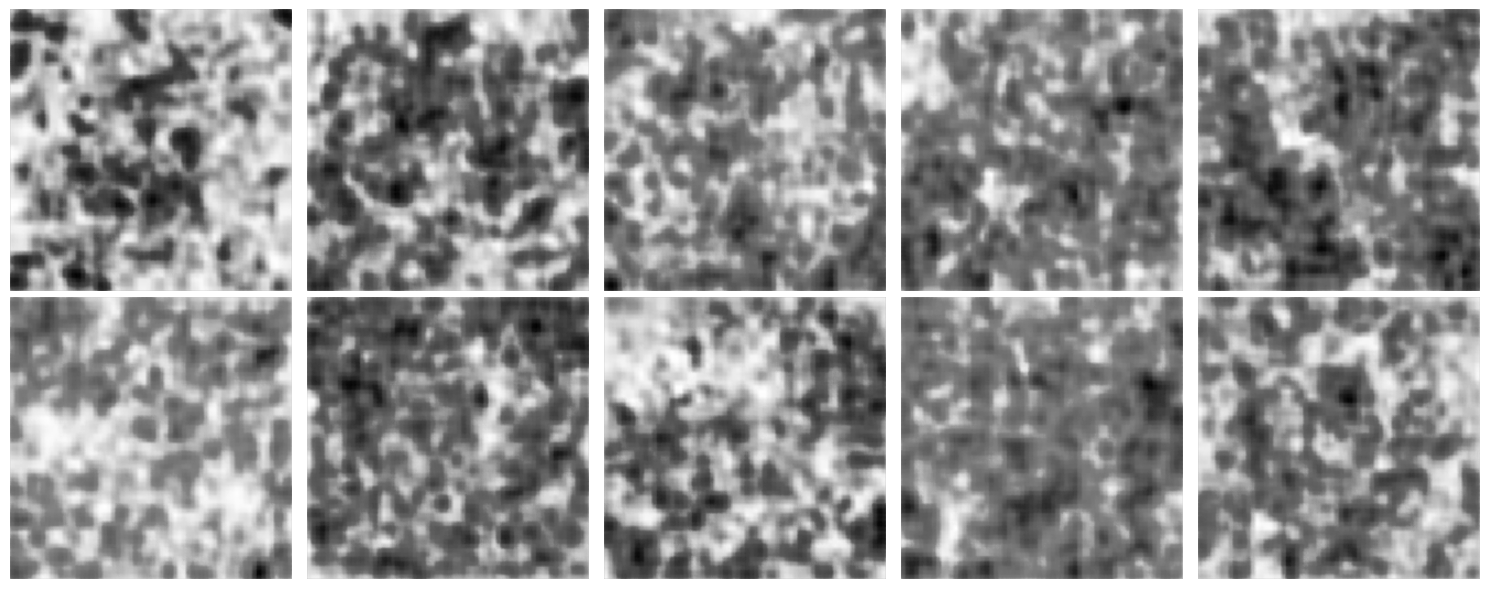

In [8]:
import torch
import matplotlib.pyplot as plt

desired_shape = (10, 1024, 1024)
reshaped_tensor = samples.view(desired_shape)
# Display the images using Matplotlib
def display_images(images_tensor):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))

    for i, ax in enumerate(axs.flatten()):
        image = images_tensor[i].cpu().detach().numpy()
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display the images from the tensor
display_images(reshaped_tensor)



Getting the histograms we created from the encoded parts to see how do they look

torch.Size([11, 24576])
<class 'list'>
<class 'int'>


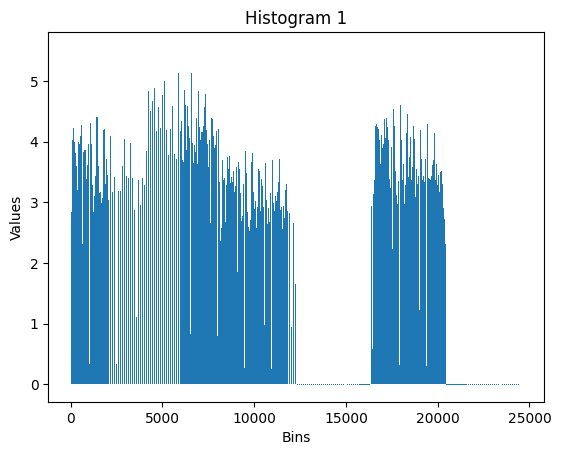

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7fca4b0a6050> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fca4b0a52d0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
print(all_vectors.size())
histograms = []
print(type(histograms))
#for row in all_vectors:
#  print(row)
#  histogram = torch.histc(row, bins=num_bins)
#  histograms.append(histogram)

bins = all_vectors.size()[1]
print(type(bins))

#histograms_tensor = torch.stack(histograms)
for i, row in enumerate(all_vectors):
  plt.figure()
  plt.bar(range(bins), row.detach().numpy())
  plt.xlabel('Bins')
  plt.ylabel('Values')
  plt.title(f'Histogram {i+1}')
  plt.savefig(f'InDomain/histogram_{i+1}.png')
  plt.show()

Good way to see the images and understand how the autoencoder is performing the task!

In [ ]:
plt.gray()
for i, item in enumerate(image_tensor):
   print("Original Images!")
   print(i)
   item = item.reshape((-1, 1024, 1024))
   plt.imshow(item[0].cpu())
   plt.show()
for i, item in enumerate(all_outputs):
   print("Reconstructed Images!")
   item = item.reshape((-1, 1024, 1024))
   print(i)
   plt.imshow(item[0].cpu().detach().numpy())
   plt.show()

In [ ]:
print()